# SP+ End-to-end Evaluation: Annotation

## 0. Setting up your environment

### 0a. git clone the mmda repo to your local device: https://github.com/allenai/mmda
Follow the instructions for setting up a virtual environment/requirements for working with this repo. You may need to install various libraries/packages. 
**Make sure you activate the env using:** _conda activate mmda_

### 0b. git clone extract-stuff-from-pdfs repo to your local device: https://github.com/allenai/extract-stuff-from-pdfs
Follow the instructions for setting up your environment for this repo. __Note: This repo is only needed for visualizing the annotations, it is not needed to retrieve them from the annotation store.__

## 1. Get data from annotation store
Load data from schema into notebook.

In [1]:
# NOTE - if schema changes, need to update "annotation-type", "bib-mention-linker-source", etc... (one time only)
import urllib.request, json 

# !!!! ANNOTATOR TODO: We will need to change SHA and annotation/attribute source for each paper evaluated
sha = '17ada3c96ef888fc89f6b995d2edd19a45383423'

attributeSource = "spp-test-1"
annotationSource = "spp-test-1"

# get data from json file
with urllib.request.urlopen(f"http://annotations-api.dev.s2.allenai.org/pdf/{sha}/annotations?"
                            f"annotationSources={annotationSource}&attributeSources={attributeSource}") as url:
    data = json.load(url)
    
#sanity check, remove later
print(data)

{'docId': '17ada3c96ef888fc89f6b995d2edd19a45383423', 'attributesFromSource': {'spp-test-1': {'plain-text-doc-id': '740c1d64752b4679a742544046cf5de3452cfef4', 'mentions': {'annotation-type': ['PlainText', 'PDF'], 'mention-detection-source': 'mentions-test-3', 'bib-mention-linker-source': 'citation-links-test-1'}, 'bib-entries': {'annotation-type': 'PDF', 'bib-detection-source': 'bib_detector_test_3'}, 'bib-entry-parses': {'annotation-type': 'PDF', 'bib-parsing-source': 'bib-struct-test-1'}, 'pdf-plumber': 'pdfplumber-0.0.4'}}, 'annotationsFromSource': {}}


### 1a. Get source names and endpoint types
This part of the notebook will retreive information about where to find the annotation sources for each part - mentions, bib-entries, bib-entry-parses, and pdf plumber. It will also retreive whether the annotations for each source are in the annotation store as a PDF or plain text. These sources will be the inputs for retreiving each type of annotation from the annotation store. 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# store sources as variables in case they change later; may need to change strings if schema changes (one time only)
mention = "mentions"
bib_entries = "bib-entries"
bib_entry_parses = "bib-entry-parses"
plumber = "pdf-plumber"

# get source/stored formats in annotation store, store as variables
for source_type in data['attributesFromSource'][attributeSource]:  
    
    # mentions
    if source_type == mention:
        mention_annot_type = data['attributesFromSource'][attributeSource][source_type]['annotation-type']
        mention_bib_link_source = data['attributesFromSource'][attributeSource][source_type]['bib-mention-linker-source']
        mention_det_source = data['attributesFromSource'][attributeSource][source_type]['mention-detection-source']
        
    # bib entries
    if source_type == bib_entries:
        bib_entry_annot_type = data['attributesFromSource'][attributeSource][source_type]['annotation-type']
        bib_entry_det_source = data['attributesFromSource'][attributeSource][source_type]['bib-detection-source']

    # bib entry parses
    if source_type == bib_entry_parses:
        bib_parse_annot_type = data['attributesFromSource'][attributeSource][source_type]['annotation-type']
        bib_parse_source = data['attributesFromSource'][attributeSource][source_type]['bib-parsing-source']
        
    # pdf plumber
    if source_type == plumber:
        plumber_annot_type = ['PlainText', 'PDF'] #always has annotations from both endpoints
        plumber_source = data['attributesFromSource'][attributeSource][source_type]

# all source type values and endpoints from data
source_values = [[mention_annot_type, mention_bib_link_source, mention_det_source],
                [bib_entry_annot_type, bib_entry_det_source],
                [bib_parse_annot_type, bib_parse_source],
                [plumber_annot_type, plumber_source]]

# spot check of source types: outputs all the sources and what format they are stored in
[source for source in source_values]

[[['PlainText', 'PDF'], 'citation-links-test-1', 'mentions-test-3'],
 ['PDF', 'bib_detector_test_3'],
 ['PDF', 'bib-struct-test-1'],
 [['PlainText', 'PDF'], 'pdfplumber-0.0.4']]

### 1b. Retrieve Annotations for tokens, rows, and pages
Using the sources obtained from the previous cell, we will now retreive the annotations for each source depending on if they are in the annotation store as a PDF or plain text.

In [21]:
""" NOTE:
      For the provided sample, we are getting annotations from prod annotations-api.
      When the data is actually run through SPP, they will be in dev annotations-api.
      Will need to modify "http://annotations-api.prod.s2...." --> "http://annotations-api.dev.s2...."
"""

#!/usr/bin/env python3
import boto3
import requests

from mmda.types.span import Span
from mmda.types.annotation import SpanGroup, Box
from mmda.types.document import Document


# method that gets url to help create span group
def get_text(url: str) -> str:
    s3 = boto3.resource('s3')
    url_no_prefix = url[5:]
    bucket, *key = url_no_prefix.split("/")
    key = "/".join(key)
    with s3.Bucket(bucket).Object(key).get()['Body'] as f:
        return f.read().decode('utf-8')

#### Part 1: PDF Plumber
Get pdf plumber data - Need to use text id, text_url from this block in the rest of the annotations.

In [5]:
#PDF PLUMBER: 1
#request annots where source = plumber_source
resp1 = requests.get(f'http://annotations-api.prod.s2.allenai.org/pdf/{sha}/annotations?annotationSources=none&attributeSources={plumber_source}').json()

#get text_url which is needed to get text (which is needed to make initial annotation doc per paper)
text_url = resp1['attributesFromSource'][plumber_source]['text']
print("text_url:", text_url)

#returns id and s3 url, use this to get text id
resp2 = requests.post(
    'http://annotations-api.prod.s2.allenai.org/plain-text/',
    json={'s3Url': text_url}
).json()
text_id = resp2['id']
print("\ntext_id:",text_id)

#gets document id which is the same throughout all types of annotations; will resuse for future cells
#be careful of plain-text vs. pdf endpoint
resp3 = requests.get(f'http://annotations-api.prod.s2.allenai.org/plain-text/{text_id}/annotations'
                     f'?annotationSources=vila-0.0.2|layout-parser-0.0.2|{plumber_source}'
                     '&attributeSources=none').json()


#getting annotations from plumber_source
vila_annos = resp3['annotationsFromSource'][f'vila-0.0.2|layout-parser-0.0.2|{plumber_source}']['vila_span_groups']
#print(resp3['annotationsFromSource'][f'vila-0.0.2|layout-parser-0.0.2|{plumber_source}']['vila_span_groups'])

#need this to create span group
text = get_text(text_url)
vila_spangroups = []
for anno in vila_annos:
    vila_spangroups.append(
        SpanGroup(
            spans=[Span(start=anno['startChar'], end=anno['endChar'])],
            type=anno['attributesFromSource'][f'vila-0.0.2|layout-parser-0.0.2|{plumber_source}']['type']
        )
    )

#create initial document
doc = Document(text)

#annotate annotatiosn onto doc
doc.annotate(vila=vila_spangroups)

#spot check
print(vila_spangroups[0])

text_url: s3://ai2-s2-science-parse-plus-prod/document/17ada3c96ef888fc89f6b995d2edd19a45383423/pdfplumber-0.0.4/text

text_id: 740c1d64752b4679a742544046cf5de3452cfef4
SpanGroup(uuid='35d314c6-b54a-4ea9-a8ad-348abf26c93b', doc=<mmda.types.document.Document object at 0x7fa62d7ba2b0>, metadata=Metadata({'id': None, 'type': 'Title', 'text': None}), spans=[Span(start=0, end=125, box=None)], box_group=None, id=None, type='Title', text='1\nFunctions of FMS-like tyrosine kinase 3 (flt3) in zebrafish hematopoiesis and its\nrelevance to human acute myeloid leukemia')


In [6]:
#PDF PLUMBER: 2
def make_span_groups(text_spans, pdf_boxes):
    
    instance_tokens = []
    for i, text_span in enumerate(text_spans):
        box_info = pdf_boxes[i]
        associated_box = Box(
            l=box_info['x'], 
            t=box_info['y'], 
            w=box_info['width'], 
            h=box_info['height'], 
            page=box_info['page']
        )

        instance_tokens.append(
            SpanGroup(
                spans=[Span(start=text_span['startChar'], end=text_span['endChar'], box=associated_box)],
                id=text_span['attributesFromSource']['pdfplumber-0.0.4']['id']

            )
        )
    return instance_tokens
    

symbols = text
pdf_plumber_text_annos_resp = requests.get(f'http://annotations-api.prod.s2.allenai.org/plain-text/{text_id}/annotations'
                     '?annotationSources=pdfplumber-0.0.4'
                     '&attributeSources=none').json()
pdf_plumber_pdf_annos_resp = requests.get(f'http://annotations-api.prod.s2.allenai.org/pdf/{sha}/annotations'
                     '?annotationSources=pdfplumber-0.0.4'
                     '&attributeSources=none').json()

#need these to later annotate boxgroups to the mmda doc
token_spans = pdf_plumber_text_annos_resp['annotationsFromSource']['pdfplumber-0.0.4']['tokens']
token_boxes = pdf_plumber_pdf_annos_resp['annotationsFromSource']['pdfplumber-0.0.4']['tokens']
page_spans = pdf_plumber_text_annos_resp['annotationsFromSource']['pdfplumber-0.0.4']['pages']
page_boxes = pdf_plumber_pdf_annos_resp['annotationsFromSource']['pdfplumber-0.0.4']['pages']
row_spans = pdf_plumber_text_annos_resp['annotationsFromSource']['pdfplumber-0.0.4']['rows']
row_boxes = pdf_plumber_pdf_annos_resp['annotationsFromSource']['pdfplumber-0.0.4']['rows']

instance_tokens = make_span_groups(token_spans, token_boxes)
instance_rows = make_span_groups(row_spans, row_boxes)
instance_pages = make_span_groups(page_spans, page_boxes)

# rows/pages specific to PDF Plumber annotations
rows = pdf_plumber_text_annos_resp['annotationsFromSource']['pdfplumber-0.0.4']['rows']
pages = pdf_plumber_text_annos_resp['annotationsFromSource']['pdfplumber-0.0.4']['pages']
vila_span_groups = vila_spangroups
print(vila_span_groups[0])

SpanGroup(uuid='35d314c6-b54a-4ea9-a8ad-348abf26c93b', doc=<mmda.types.document.Document object at 0x7fa62d7ba2b0>, metadata=Metadata({'id': None, 'type': 'Title', 'text': None}), spans=[Span(start=0, end=125, box=None)], box_group=None, id=None, type='Title', text='1\nFunctions of FMS-like tyrosine kinase 3 (flt3) in zebrafish hematopoiesis and its\nrelevance to human acute myeloid leukemia')


#### Part 2: Mentions
Get mentions annotations from annotation store

In [7]:
#retrieve mentions boxes and spans (box = pdf) (spans = plain-text)

#annotation sources = variables found above
#attribute sources = all
ment_resp1 = requests.get(f'https://annotations-api.dev.s2.allenai.org/pdf/{sha}/'
                     f'annotations?annotationSources={mention_det_source}&attributeSources=all').json()


#Plain-Text endpoint - get spans
ment_resp3 = requests.get(f'http://annotations-api.dev.s2.allenai.org/plain-text/{text_id}/annotations'
                         f'?annotationSources={mention_det_source}'
                         '&attributeSources=all').json()
#print(ment_resp3)

#getting annotations from mentions
anno_mentions = ment_resp3['annotationsFromSource'][f'{mention_det_source}']['mentions']

#need to combine spans and boxes into single span group, which can then be annotated onto mmda doc
# method that combines box and text spans - specific to mentions
def make_span_groups(text_spans, pdf_boxes):
    
    instance_tokens = []
    for i, text_span in enumerate(text_spans):
        box_info = pdf_boxes[i]
        associated_box = Box(
            l=box_info['x'], 
            t=box_info['y'], 
            w=box_info['width'], 
            h=box_info['height'], 
            page=box_info['page']
        )

        instance_tokens.append(
            SpanGroup(
                spans=[Span(start=text_span['startChar'], end=text_span['endChar'], box=associated_box)],
                id=text_span['attributesFromSource'][f'{mention_det_source}']
            )
        )
    return instance_tokens

# create span group
#initialize mentions spangroup list
ment_spangroups = []
for anno in anno_mentions: #sub in new variable here
    ment_spangroups.append(
        SpanGroup(
            spans=[Span(start=anno['startChar'], end=anno['endChar'])],
            type=anno['attributesFromSource'][f'{mention_det_source}']['group']
        )
    )

symbols = text
ment_text_annos_resp = requests.get(f'http://annotations-api.dev.s2.allenai.org/plain-text/{text_id}/annotations'
                     f'?annotationSources={mention_det_source}'
                     '&attributeSources=none').json()

ment_pdf_annos_resp = requests.get(f'http://annotations-api.dev.s2.allenai.org/pdf/{sha}/annotations'
                     f'?annotationSources={mention_det_source}'
                     '&attributeSources=none').json()

token_boxes = ment_pdf_annos_resp['annotationsFromSource'][f'{mention_det_source}']['mentions']
token_spans = ment_text_annos_resp['annotationsFromSource'][f'{mention_det_source}']['mentions']

instance_tokens = make_span_groups(token_spans, token_boxes)


#annotate annotations onto doc
doc.annotate(mentions=ment_spangroups)

#print span group spot check
print(ment_spangroups[0])

SpanGroup(uuid='95ed96b6-d340-4911-9dc7-188b370351e7', doc=<mmda.types.document.Document object at 0x7fa62d7ba2b0>, metadata=Metadata({'id': None, 'type': 0, 'text': None}), spans=[Span(start=4376, end=4381, box=None)], box_group=None, id=None, type=0, text='12,13')


### Part 3: Bib-Entries
Get bib-entry annotations from annotation store

In [8]:
#retrieve bib-entry annotations
#pdf endpoint
bib_resp1 = requests.get(f'https://annotations-api.dev.s2.allenai.org/pdf/{sha}/'
                     f'annotations?annotationSources={bib_entry_det_source}&attributeSources=all').json()


#plain-text endpoint
#not actually being used here
bib_resp3 = requests.get(f'http://annotations-api.dev.s2.allenai.org/plain-text/{text_id}/annotations'
                         f'?annotationSources={bib_entry_det_source}'
                         '&attributeSources=all').json()

#getting annotations from mentions
#you may need to change bib_resp1 to bib_resp3 if the annotation type listed is plain-text (rather than PDF)
anno_bib = bib_resp1['annotationsFromSource'][f'{bib_entry_det_source}']['bib-entries']
#print(anno_bib)

#need pages, tokens, spans and rows
# !!!! ANNOTATOR TODO: need to un-comment these annotation calls 
#only do this once per run, otherwise it prompts you to overwrite 
doc.annotate(pages=instance_pages)
doc.annotate(tokens=instance_tokens)
doc.annotate(rows=instance_rows)

# need to create box groups
# bib_entry_boxgroups_json to spangroups to json:
from mmda.types.annotation import BoxGroup
from copy import copy
import itertools

def box_groups_json_to_boxgroups(box_groups_json):

    counter = itertools.count()
    
    # make BoxGroups from Json
    boxgroups = []
    for bg in box_groups_json:
        box_info = bg
        box = Box(
            l=box_info['x'], 
            t=box_info['y'], 
            w=box_info['width'], 
            h=box_info['height'],            
            page=box_info['page']
        )
        boxgroups.append(
        BoxGroup(boxes=[box],
                 id=next(counter) # OR update models?
                )
        )
    print(boxgroups[0])
    return boxgroups

bib_box_groups = box_groups_json_to_boxgroups(anno_bib)

# !!!! ANNOTATOR TODO: uncomment "doc.annotate..." for each run
#annotate annotations onto doc (only do once or get overwrite error)
doc.annotate(bibs=bib_box_groups)

#check that they are spans
print(doc.bibs[0])

BoxGroup(uuid='2b5535da-cb2a-42b3-9445-4582ee4526e0', doc=None, metadata=Metadata({'id': 0, 'type': None}), boxes=[Box(l=0.18146317915032664, t=0.866992529633839, w=0.6380922541862745, h=0.06077997036616102, page=12)], id=0, type=None)
SpanGroup(uuid='d615baae-bb0b-4a7e-9fae-2801da0e8248', doc=<mmda.types.document.Document object at 0x7fa62d7ba2b0>, metadata=Metadata({'id': 0, 'type': None, 'text': None}), spans=[], box_group=BoxGroup(uuid='2b5535da-cb2a-42b3-9445-4582ee4526e0', doc=None, metadata=Metadata({'id': 0, 'type': None}), boxes=[Box(l=0.18146317915032664, t=0.866992529633839, w=0.6380922541862745, h=0.06077997036616102, page=12)], id=0, type=None), id=0, type=None, text='')


#### Citation Mention LINKS

In [9]:
citation_links_instance = {
    "symbols": symbols,
    "mentions" : [sg.to_json() for sg in doc.mentions],
    "bibs" : [sg.to_json() for sg in doc.bibs],
}

#print(citation_links_instance['bibs'][:2])

citation_links_response = requests.post(
    'http://citation-links.v0.prod.models.s2.allenai.org/invocations',
    json={'instances': [citation_links_instance]}
)

def link_to_boxgroups(box_groups_json):

    counter = itertools.count()
    
    # make BoxGroups from Json
    boxgroups = []
    for bg in box_groups_json:
        box_info = bg
        box = Box(
            l=box_info[0], 
            t=box_info[1], 
            w=box_info[2], 
            h=box_info[3],            
            page=box_info[4]
        )
        boxgroups.append(
        BoxGroup(boxes=[box],
                 id=next(counter) # OR update models?
                )
        )
    print(boxgroups[0])
    return boxgroups


link_box_groups = link_to_boxgroups(citation_links_response)

#dir(doc)

BoxGroup(uuid='a765f71f-a777-4a23-8ef1-03cdcce06b87', doc=None, metadata=Metadata({'id': 0, 'type': None}), boxes=[Box(l=123, t=34, w=100, h=101, page=116)], id=0, type=None)


### Part 4: Bib-Parse 
Get bib-parse-entry annotations from annotation store

In [10]:
#retrieve bib parse data
#pdf endpoint
bib_parse_resp1 = requests.get(f'https://annotations-api.dev.s2.allenai.org/pdf/{sha}/'
                     f'annotations?annotationSources={bib_parse_source}&attributeSources={bib_parse_source}').json()

#plain-text endpoint
#not actually being used here
bib_parse_resp3 = requests.get(f'http://annotations-api.dev.s2.allenai.org/plain-text/{text_id}/annotations'
                         f'?annotationSources={bib_parse_source}'
                         '&attributeSources=all').json()
#print(bib_parse_resp3)

#getting annotations from bib parse
#you may need to change bib_resp1 to bib_resp3 if the annotation type listed is plain-text (rather than PDF)
anno_bib_parse = bib_parse_resp3['annotationsFromSource'][f'{bib_parse_source}']['bib_entry_title']
#print(anno_bib_parse)

#initialize bib parse spangroup list
bib_parse_spangroups = []

# need this to create span group
for anno in anno_bib_parse: #sub in new variable here
    bib_parse_spangroups.append(
        SpanGroup(
            spans=[Span(start=anno['startChar'], end=anno['endChar'])],
            type=anno['attributesFromSource'][f'{bib_parse_source}']
        )
    )

#annotate annotations onto doc
doc.annotate(bib_parse=bib_parse_spangroups)

#print span group spot check
print(bib_parse_spangroups[0])

SpanGroup(uuid='1d6ebf60-e77b-4c22-a590-8852b6c846db', doc=<mmda.types.document.Document object at 0x7fa62d7ba2b0>, metadata=Metadata({'id': None, 'type': {'text': 'The role of FLT3 in haematopoietic malignancies', 'group': 0}, 'text': None}), spans=[Span(start=34134, end=34181, box=None)], box_group=None, id=None, type={'text': 'The role of FLT3 in haematopoietic malignancies', 'group': 0}, text='The role of FLT3 in haematopoietic malignancies')


### Part 5: Images
Annotate images onto the mmda doc.

In [11]:
from mmda.rasterizers.rasterizer import PDF2ImageRasterizer

# !!! ANNOTATOR TODO: update file path to your file path containing pdfs (one time only)

#annotate images to doc; only do once per run of notebook
#temporarily manually enter file name/path
rasterizer = PDF2ImageRasterizer()
images = rasterizer.rasterize(input_pdf_path=f'/Users/baileyk/Projects/SP_end_to_end/extract-stuff-from-pdfs/eval_papers/pdfs/{sha}.pdf', dpi=72)
doc.annotate_images(images=images)


### 1c. Check to make sure you have annotated all fields onto mmda doc
Should be: 'vila', 'mentions', 'pages', 'tokens', 'rows', 'bibs', 'bib_parse', 'images'

In [20]:
print(doc.fields)

#print(doc.mentions[0].tokens[0].spans[0])
#print(doc.mentions[0].tokens[0].spans[0].box.page)

#print(doc.images)
#print(doc.bibs)

#print(doc.mentions[6].metadata)
#print(doc.images)

['vila', 'mentions', 'pages', 'tokens', 'rows', 'bibs', 'bib_parse']
28


## 2. Visalize Paper and Draw boxes on mentions
Use draw boxes to visualize each mention

### 2a. Import Statements and Random page

In [22]:
import random # to get random page number to annotate

# !!!! ANNOTATOR TODO: Record page # from output in annotation spreadsheet
# get random page number to review and annotate
page = random.randrange(1,len(doc.pages)) #bailey todo: change range end at # of pages in pdf
print("page to annotate:", page)

page to annotate: 13


In [15]:
import sys
import os
import json
%matplotlib inline
import matplotlib.pyplot as plt
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List


# adding folder to the system path
sys.path.insert(0, '/Users/baileyk/Projects/SP_end_to_end/extract-stuff-from-pdfs')
from common.config import get_git_root
from extract_citation_mentions import download_pdf

### 2b. Make boxgroups for mentions so that boxes can be drawn for them.

In [16]:
from collections import defaultdict

#function to create box groups from mentions on the mmda doc
def make_boxgroups_mentions(doc):

    result_boxes_list = defaultdict(list)
    dictionary_of_boxes = defaultdict(list)
       
    for mention in doc.mentions:
        for token in mention.tokens:
            for span in token.spans:
                dictionary_of_boxes[span.box.page].append(span.box)
    
    print(dictionary_of_boxes)
    #mapping between pages and spans on page
    for page, list_of_boxes in dictionary_of_boxes.items():
        page_w, page_h = doc.images[page].size


        for box in list_of_boxes:
            if box.page == page:
                result_boxes_list[page].append(lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    ))
            else:
                raise ValueError('Page number')
    return result_boxes_list

### 2c. Draw boxes given box groups.

defaultdict(<class 'list'>, {2: [Box(l=0.3673529411764706, t=0.45673090681818185, w=0.027257940653594773, h=0.00939974747474745, page=2), Box(l=0.36411764705882355, t=0.5862763613636364, w=0.02755158876470585, h=0.00939974747474745, page=2), Box(l=0.23176470588235296, t=0.6419581795454545, w=0.05784770473856206, h=0.00939974747474745, page=2), Box(l=0.7738235294117647, t=0.6787763613636364, w=0.011964883267973883, h=0.009399747474747377, page=2), Box(l=0.3032352941176471, t=0.771503634090909, w=0.011964883267973838, h=0.00939974747474752, page=2)], 3: [Box(l=0.37470588235294117, t=0.08650363409090907, w=0.01225926124183005, h=0.00939974747474752, page=3), Box(l=0.7152941176470589, t=0.10513999772727269, w=0.012259261241830141, h=0.00939974747474752, page=3), Box(l=0.8070588235294118, t=0.10513999772727269, w=0.012259261241830141, h=0.00939974747474752, page=3), Box(l=0.7055882352941176, t=0.17900363409090905, w=0.027551588764705894, h=0.00939974747474752, page=3), Box(l=0.4876470588235

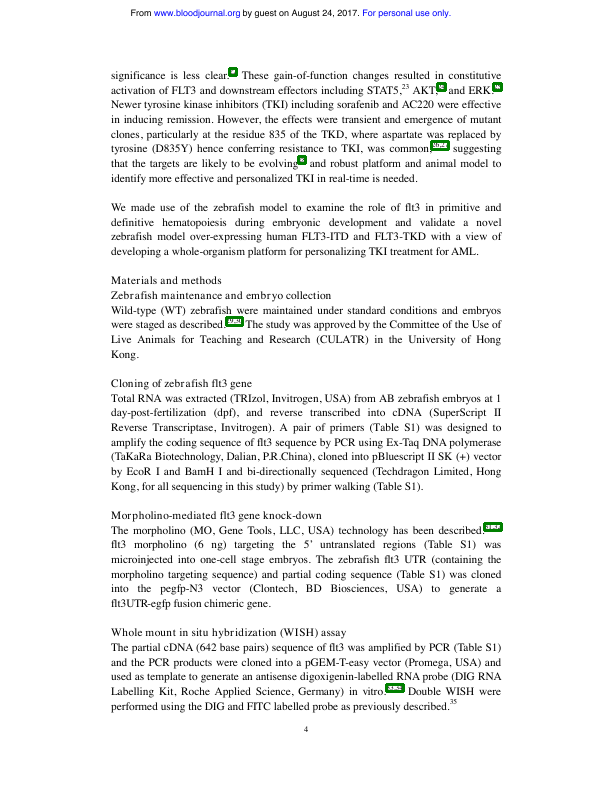

In [17]:
## can maybe use this to label mentions?
#viz = lp.draw_box(image, [ele.set(id=f"{ele.type}:{ele.score:.2f}") for ele in model_outputs], show_element_id=True)
#display(viz)

#egor version
def draw_boxgroups(image, rectangle_list, color_map=None):
    viz = []
    if color_map is None:
        color_map={'color_1': 'green', 'color_2': 'blue', 'color_3': 'yellow', 'color_4': 'pink'}

    for rectangle in rectangle_list:
        viz.append(lpe.TextBlock(rectangle, type=f'color_1')) #add id group here
        
    if image:
        return lpv.draw_box(image, viz, color_map=color_map, show_element_id=False)
    
    return None

#make boxes
dic_boxgroups = make_boxgroups_mentions(doc)

#this would display all pages of the pdf
"""for page in range(len(doc.images)):
    #draw boxes on the doc at each page in rectangle_list
    image = draw_boxgroups(doc.images[page], list(dic_boxgroups[page]))
    display(image)
"""
    
#bailey todo: remove page 
#display specific page of pdf with mentions
page=3

#sp+
image = draw_boxgroups(doc.images[page], list(dic_boxgroups[page])) #mentions

#grobid
#image = draw_boxgroups(doc.images[page], list(dic_boxgroups[page])) 

display(image)

## 3. Get references and s2 id's for each mention.

get the link data that exists in the annotation store as an attribute on the citation mention onto the citation mention spangroup, maybe as metadata

In [19]:
bib_grouped_boxes = defaultdict(list)
for bib in doc.bibs:
    for group in bib.box_group:
        bib_grouped_boxes[group.page].append(group)
#print(bib_grouped_boxes[page])

page=3

#sp+
image1 = draw_boxgroups(doc.images[page], list(bib_grouped_boxes[page])) #bibs

#not working
#display(image1)